# Описание проекта: телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Задача:** построить  модель, которая будет предсказывать, разорвёт ли абонент договор.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

**Файл contract_new.csv**
* `customerID` — идентификатор абонента;
* `BeginDate` — дата начала действия договора;
* `EndDate` — дата окончания действия договора;
* `Type` — тип оплаты: раз в год-два или ежемесячно;
* `PaperlessBilling` — электронный расчётный лист;
* `PaymentMethod` — тип платежа;
* `MonthlyCharges` — расходы за месяц;
* `TotalCharges` — общие расходы абонента.

**Файл personal_new.csv**
* `customerID` — идентификатор пользователя;
* `gender` — пол;
* `SeniorCitizen` — является ли абонент пенсионером;
* `Partner` — есть ли у абонента супруг или супруга;
* `Dependents` — есть ли у абонента дети.

**Файл internet_new.csv**
* `customerID` — идентификатор пользователя;
* `InternetService` — тип подключения;
* `OnlineSecurity` — блокировка опасных сайтов;
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
* `DeviceProtection` — антивирус;
* `TechSupport` — выделенная линия технической поддержки;
* `StreamingTV` — стриминговое телевидение;
* `StreamingMovies` — каталог фильмов.

**Файл phone_new.csv**
* `customerID `— идентификатор пользователя;
* `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**План работы**
1. Загрузка данных.
2. Исследовательский анализ и предобработка данных.
3. Объединение данных.
4. Исследовательский анализ и предобработка данных объединённого датафрейма.
5. Подготовка данных.
6. Обучение моделей машинного обучения.
7. Выбор лучшей модели.
8. Общий вывод и рекомендации заказчику.

## Загрузка данных

In [1]:
!pip -q install phik
!pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV 
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

RANDOM_STATE=141024
TEST_SIZE=0.25

In [3]:
contract_new = pd.read_csv(r'~/contract_new.csv')
personal_new = pd.read_csv(r'~/personal_new.csv')
internet_new = pd.read_csv(r'~/internet_new.csv')
phone_new = pd.read_csv(r'~/phone_new.csv')

In [4]:
def reading(data):
    display(data.head(15))
    data.info()
    display(data.describe())

In [5]:
reading(contract_new)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


* Пропуски отсутствуют.
* Есть несоответствие типов данных: BeginDat и EndDate нужно будет привести к datetime; TotalCharge нужно будет привести float.

In [6]:
reading(personal_new)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


* Пропусков нет.
* Столбец SeniorCitizen нужно привести к bool. ?

In [7]:
reading(internet_new)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


* Пропусков нет.
* Возможно, нужно будет привести столбцы к bool.

In [8]:
reading(phone_new)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


* Пропусков нет.
* Возможно, потребуется bool.

**Вывод:** 
* На первый взгляд данные чистые.
* Требуются изменения следующих типов данных в файле contract_new: BeginDat и EndDate нужно будет привести к datetime; TotalCharge нужно будет привести float.
* Целевой признак `EndDate`, который показывает, продолжает ли пользователь использовать услуги компании. 

## Предобработка данных

План работы:
1. Привести к змеиному регистру.
2. Изменить тип данных.
3. Проверить на пропуски и дубли.

In [9]:
#приводим к нужному регистру
contract_new.columns = contract_new.columns.str.lower()
internet_new.columns = internet_new.columns.str.lower()
personal_new.columns = personal_new.columns.str.lower()
phone_new.columns = phone_new.columns.str.lower()

In [10]:
#меняем тип данных
contract_new['totalcharges'] = pd.to_numeric(contract_new['totalcharges'], errors='coerce')

In [11]:
contract_new['begindate'] = pd.to_datetime(contract_new['begindate'])

Значение `No` в столбце `EndDate`означает, что абонент все еще использует услуги.
Создадим новый признак, где `No` будет равен 1, а где присутствует дата окончания, будет 0.

In [12]:
contract_new['target'] = 0
contract_new.loc[contract_new['enddate'] == 'No', 'target'] = 1

Для подсчета общего количества дней пользования, изменим `No` в EndDate на 1 февраля 2020 года. 

In [13]:
contract_new['enddate'] = contract_new['enddate'].replace(['No'], ['2020-02-01'])
contract_new['enddate'] = pd.to_datetime(contract_new['enddate'])

In [14]:
contract_new['totaldays'] = (contract_new['enddate'] - contract_new['begindate']).dt.days

In [15]:
contract_new.head(15)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,totaldays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,1,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,1,153
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,1,337
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,1,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,1,306
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,1,945
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,0,882


Теперь можно удалить признак `enddate`, так как в нем больше нет необходимости.

In [16]:
contract_new.drop('enddate', axis=1, inplace=True)

In [17]:
def prep(data, name='DataFrame'):
    print(f'Количество дубликатов в {name}:', data.duplicated(subset=data.columns).sum())
    print('\n')
    print(f'Количество пропусков в {name}:\n', data.isna().sum())

In [18]:
prep(contract_new, name='contract_new')

Количество дубликатов в contract_new: 0


Количество пропусков в contract_new:
 customerid           0
begindate            0
type                 0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
target               0
totaldays            0
dtype: int64


После изменения типа данных появились пропуски.

In [19]:
contract_new[contract_new['totalcharges'].isna()]

,customerid,begindate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,totaldays
488,4472-LVYGI,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,1,0
753,3115-CZMZD,2020-02-01,Two year,No,Mailed check,20.25,NaN,1,0
936,5709-LVOEQ,2020-02-01,Two year,No,Mailed check,80.85,NaN,1,0
1082,4367-NUYAO,2020-02-01,Two year,No,Mailed check,25.75,NaN,1,0
1340,1371-DWPAZ,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,1,0
3331,7644-OMVMY,2020-02-01,Two year,No,Mailed check,19.85,NaN,1,0
3826,3213-VVOLG,2020-02-01,Two year,No,Mailed check,25.35,NaN,1,0
4380,2520-SGTTA,2020-02-01,Two year,No,Mailed check,20.00,NaN,1,0
5218,2923-ARZLG,2020-02-01,One year,Yes,Mailed check,19.70,NaN,1,0
6670,4075-WKNIU,2020-02-01,Two year,No,Mailed check,73.35,NaN,1,0


 totaldays равен `Nan`. Скорее всего, это новые пользователи. Заполним тогда 0.

In [20]:
contract_new['totalcharges'] = contract_new['totalcharges'].replace(np.nan, 0)

In [21]:
prep(internet_new, name='internet_new')

Количество дубликатов в internet_new: 0


Количество пропусков в internet_new:
 customerid          0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
dtype: int64


In [22]:
prep(personal_new, name='personal_new')

Количество дубликатов в personal_new: 0


Количество пропусков в personal_new:
 customerid       0
gender           0
seniorcitizen    0
partner          0
dependents       0
dtype: int64


In [23]:
prep(phone_new, name='phone_new')

Количество дубликатов в phone_new: 0


Количество пропусков в phone_new:
 customerid       0
multiplelines    0
dtype: int64


Таким образом, мы изменили тип данных, где это нужно, и добавили новые признаки: количество дней и целевой признак, который показывает, продолжает ли абонент еще пользоваться услугами.

## Объединение данных

Объединим датасеты по `customerid`

In [24]:
df = (
    contract_new
.merge(personal_new, how='left', on='customerid')
.merge(internet_new, how='left', on='customerid')
.merge(phone_new, how='left', on='customerid')
     )

In [25]:
#для проверки уникальности customerid
df['customerid'].is_unique

True

In [26]:
reading(df)

,customerid,begindate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,totaldays,gender,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,2071.84,1,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,Month-to-month,Yes,Electronic check,99.65,1150.96,1,337,Female,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,1,671,Male,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,Month-to-month,No,Mailed check,29.75,300.48,1,306,Female,...,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,Month-to-month,Yes,Electronic check,104.80,3573.68,1,945,Female,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,One year,No,Bank transfer (automatic),56.15,1628.35,0,882,Male,...,No,Yes,DSL,Yes,Yes,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   float64       
 7   target            7043 non-null   int64         
 8   totaldays         7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity    5517 n

,monthlycharges,totalcharges,target,totaldays,seniorcitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.843675,898.555729,0.162147
std,30.090047,2112.742814,0.363189,683.130510,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,1.000000,276.000000,0.000000
50%,70.350000,1343.350000,1.000000,761.000000,0.000000
75%,89.850000,3236.690000,1.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


In [27]:
prep(df)

Количество дубликатов в DataFrame: 0


Количество пропусков в DataFrame:
 customerid             0
begindate              0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
target                 0
totaldays              0
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
multiplelines        682
dtype: int64


Появились пропуски в столбцах `internetservice`, `onlinesecurity`,`onlinebackup`, `deviceprotection`, `techsupport`, `streamingtv`, `streamingmovies`, `multiplelines`. Возможно, эти столбцы не были заполнены по техническим причинам (например, данные не сохранились). Заполнить `No_service`

In [28]:
columns = ['internetservice','onlinesecurity','onlinebackup','deviceprotection', 
        'techsupport','streamingtv', 'streamingmovies','multiplelines']

for column in columns:
    df[column] = df[column].fillna('No_service')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   float64       
 7   target            7043 non-null   int64         
 8   totaldays         7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   7043 non-null   object        
 14  onlinesecurity    7043 n

Мы объединили датасеты, заполнив пропуски `No_service`.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Построим графики для категориальных данных.

In [30]:
def cat_plot(df, column):
    display(df[column].unique())
    plt.figure(figsize=(9,7))
    sns.countplot(y=column, data=df)
    plt.title(f'Рапределение по {column}', fontsize=16)
    plt.xlabel('Количество', fontsize=14)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   float64       
 7   target            7043 non-null   int64         
 8   totaldays         7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   7043 non-null   object        
 14  onlinesecurity    7043 n

In [32]:
categorial_columns = ['type', 'paperlessbilling','paymentmethod', 'gender', 'partner', 'dependents', 'internetservice', 
                      'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 
                     'multiplelines', 'seniorcitizen', 'target']
num_columns = ['monthlycharges', 'totalcharges', 'totaldays']

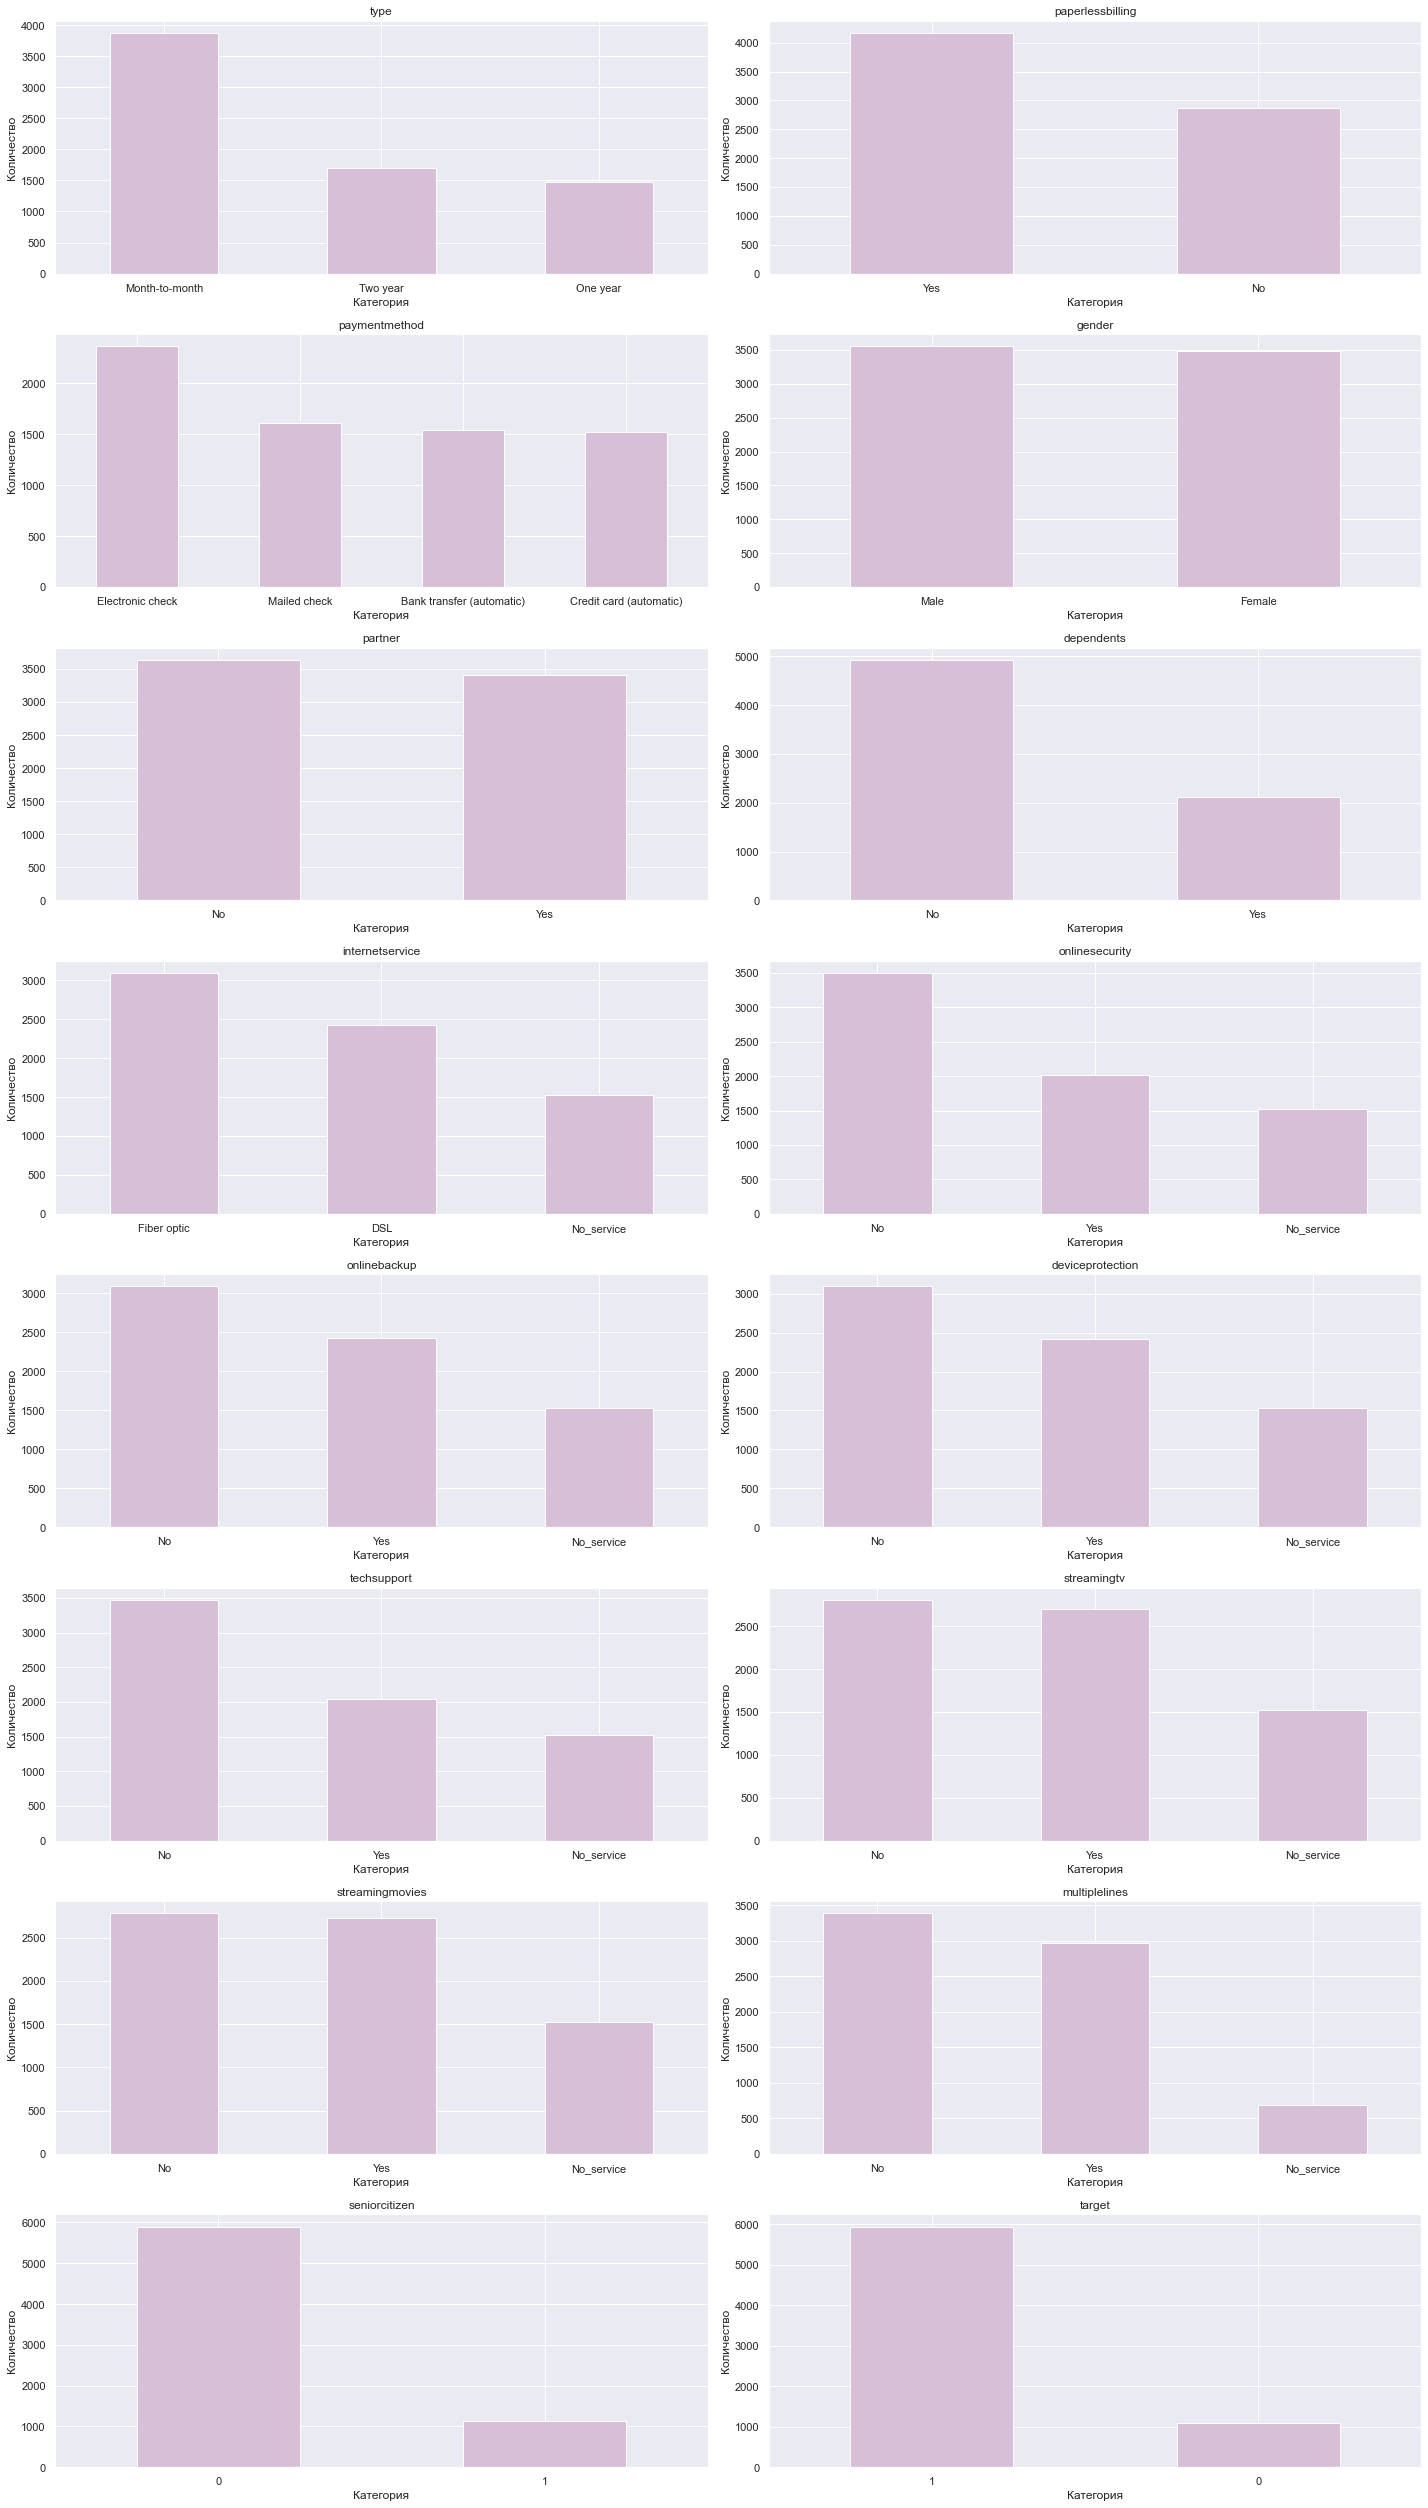

In [33]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))


plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorial_columns):
    sns.set()
    ax = plt.subplot(rows, cols, idx + 1)
    
    df[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
        color='thistle'
    )
    
    ax.set_xlabel('Категория') 
    ax.set_ylabel('Количество')
        
plt.tight_layout()
plt.show()

* Тип оплаты: лидирует month-to-month.
* Электронный расчётный лист чаще с согласием.
* Тип платежа чаще всего электронный чек.
* Столбцы `gender` и `partner`  распределены равномерны. 
* У большинства нет детей.
* Популярный тип подключения Fiber optic.
* Пенсионеры редко пользуются услугами.
* Остальные услуги `onlinebackup`, `deviceprotection`, `techsupport`, `streamingtv`, `streamingmovies`, `multiplelines` не пользуются популярностью. Также некоторая часть неизвестна.
* Большая часть абонентов еще пользуются услугами.

Посмотрим теперь на количественные данные.

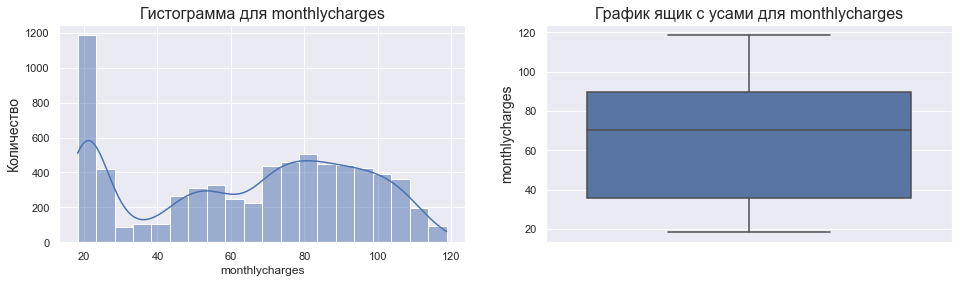

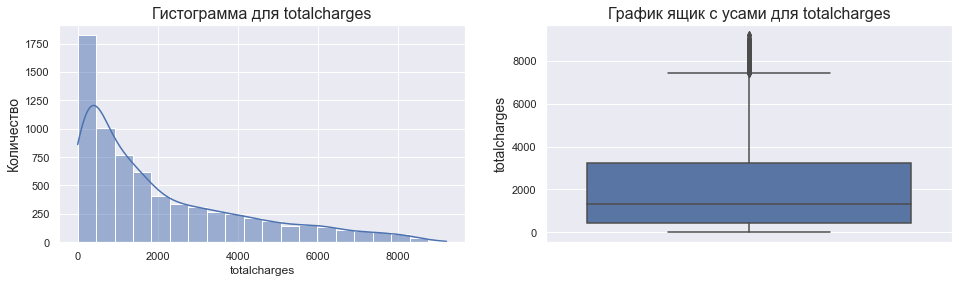

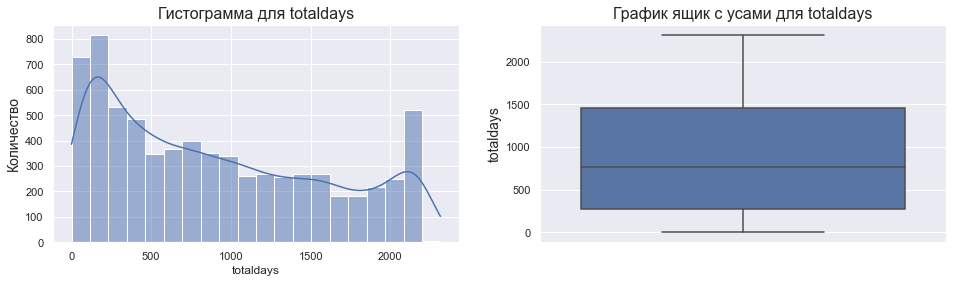

In [34]:
for idx, column in enumerate(num_columns):
    
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(f'Гистограмма для {column}', fontsize=16)
    axes[0].set_ylabel('Количество', fontsize=14)
    sns.histplot(df, bins=20, kde=True, ax=axes[0], x=column)
    
    axes[1].set_title(f'График ящик с усами для {column}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=column)
    axes[1].set_ylabel(column, fontsize=14)
    
    plt.show()

* В MonthlyCharges заметен пик около 20, который соответствует минимальному значению. 
* Значения в столбце TotalCharges уменьшаются, в то время как в столбце MonthlyCharges наблюдается пик около 80, что указывает на то, что пользователи, платящие высокую сумму за тариф, не задерживаются надолго. 
* В столбце TotalDays можно выделить два пика: один — среди новых клиентов, а другой — среди "пользователей-старичков".
* Аномальных значений не наблюдается.

Посмотрим на распределение признаков в разрезе оттока: сначала на количественные, потом на категориальные данные.

In [35]:
def outflow_num(column, bins):
    plt.figure(figsize=(10, 6))
    
    ax = sns.histplot(
        data=df,
        x=column,
        hue='target',
        stat='density',
        common_norm=False,
        bins=bins,
        hue_order=df['target'].unique() 
    )

    plt.title('Распределение значений с учетом оттока')
    plt.xlabel(column)
    plt.ylabel('Плотность')

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(['Отток', 'Не отток'])

    plt.show()

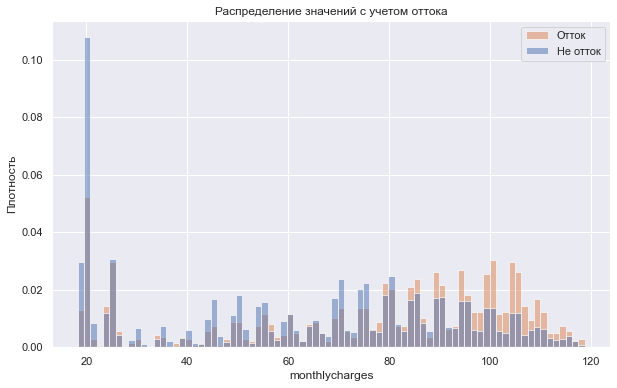

In [36]:
outflow_num('monthlycharges', 80)

Клиенты, которые использовали более дорогие тарифы, чаще отказывались от услуг.

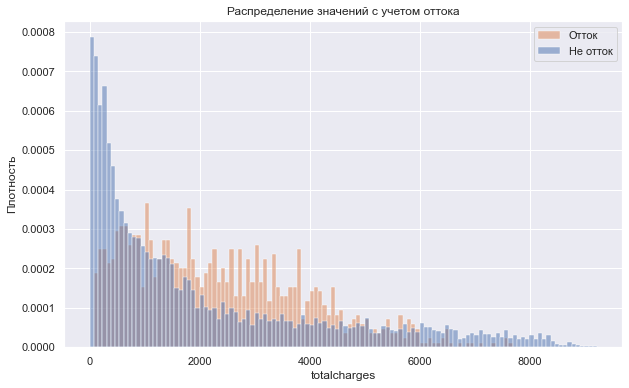

In [37]:
outflow_num('totalcharges', 120)

Пользователи, в сумме которые платили меньше, чаще остаются пользователями.

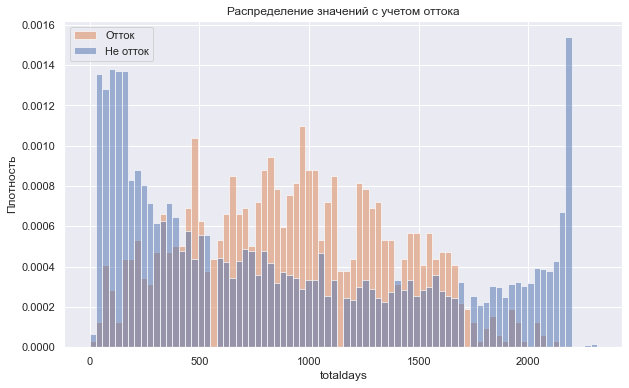

In [38]:
outflow_num('totaldays', 80)

Здесь наблюдаем два пика пользователей: либо они только начали пользоваться, либо уже являются "старичками". Как раз в середине периода наибольшее количество клиентов перестают пользоваться услугами. Возможно, именно здесь нужно что-то предпринимать.

In [39]:
def outflow_cat(column):
    
    average_target = df['target'].mean()  

    plt.figure(figsize=(12, 6))
    sns.barplot(x=column, y='target', data=df, ci=None)  
    plt.axhline(average_target, color='red', linestyle='--', label='Средний уровень оттока')
    plt.title('Уровень оттока по категориям')
    plt.xlabel(column)
    plt.ylabel('Уровень оттока')
    plt.legend()
    
    plt.show()

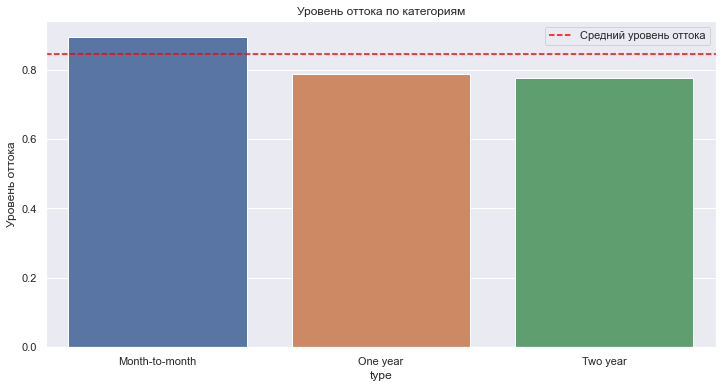

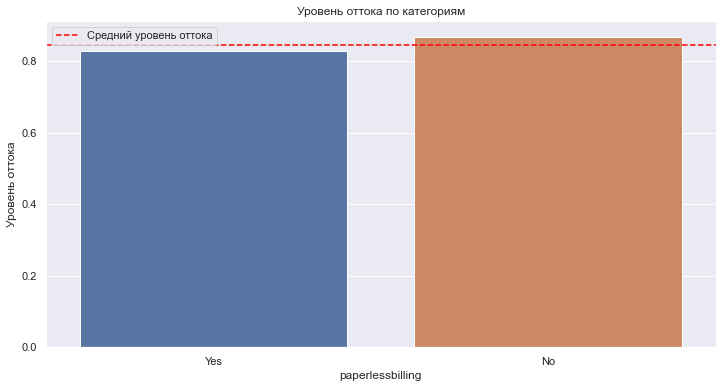

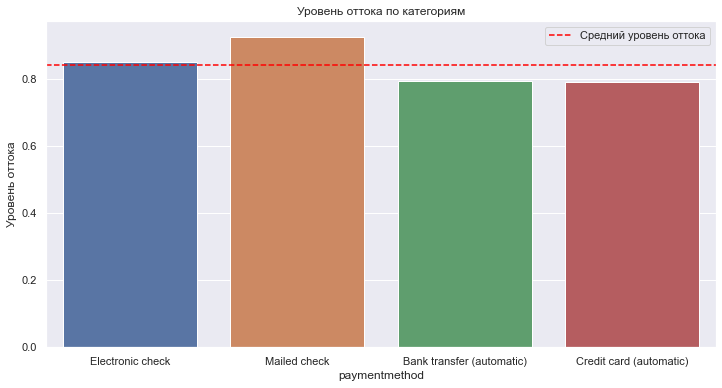

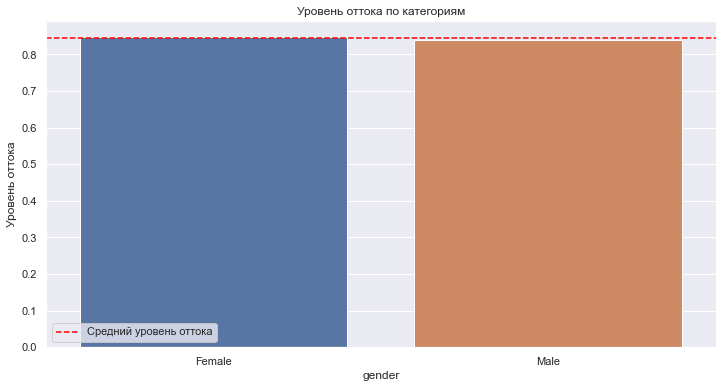

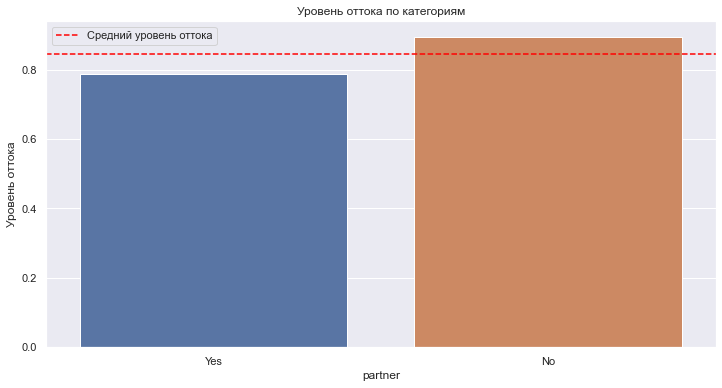

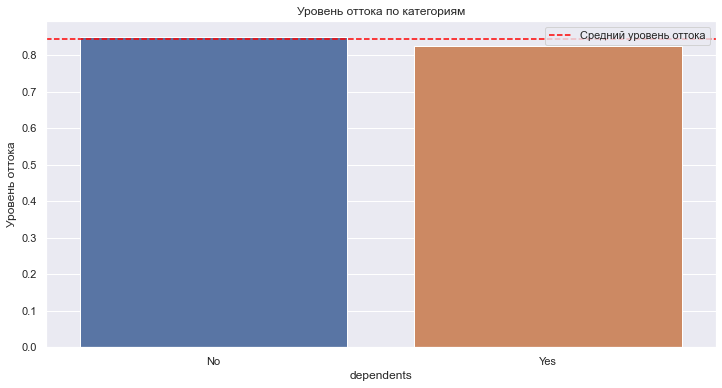

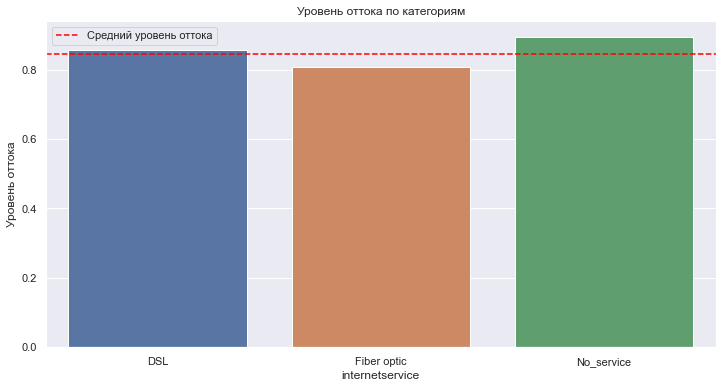

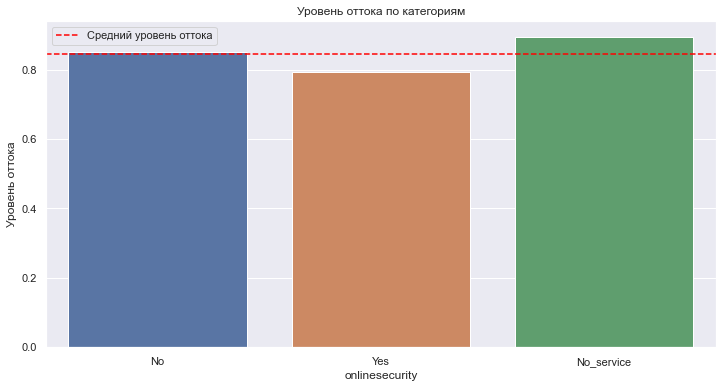

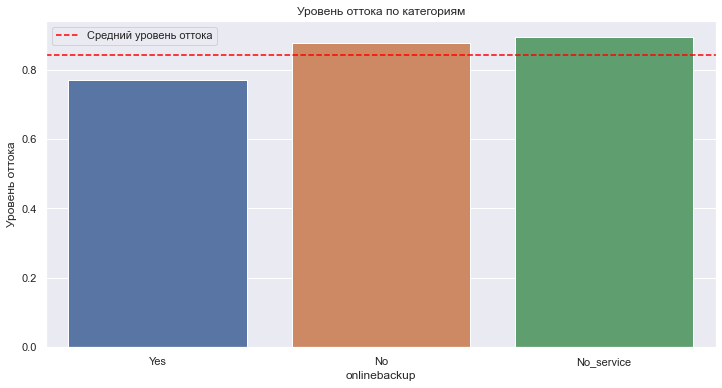

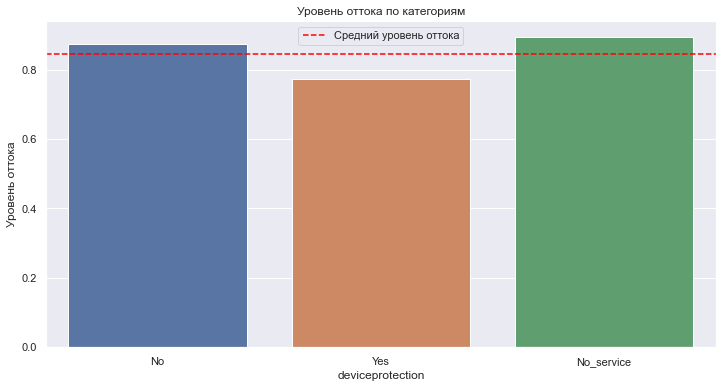

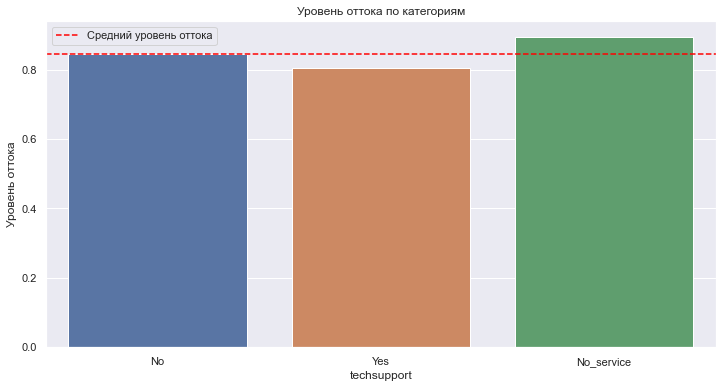

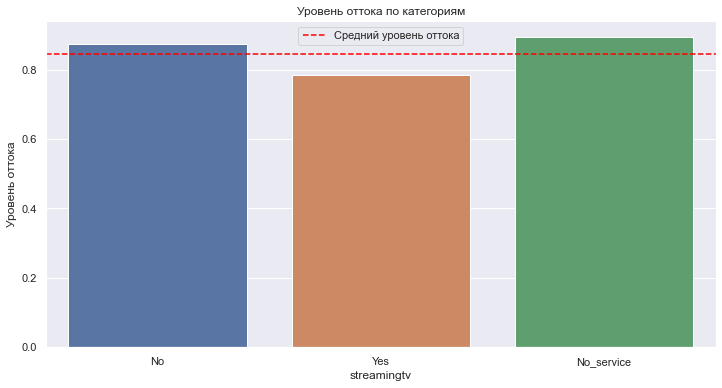

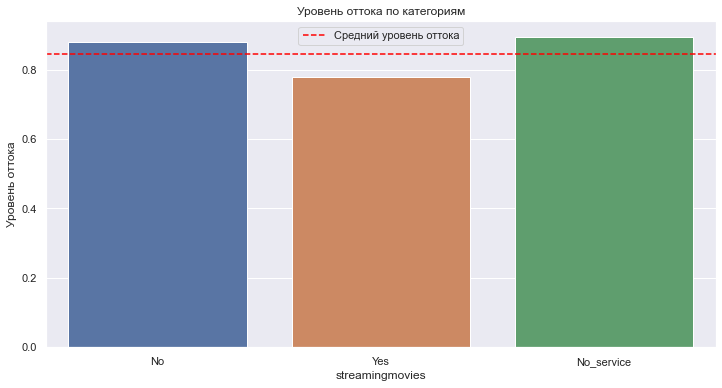

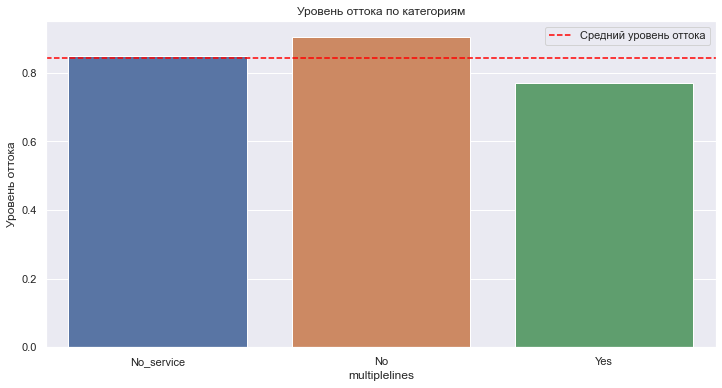

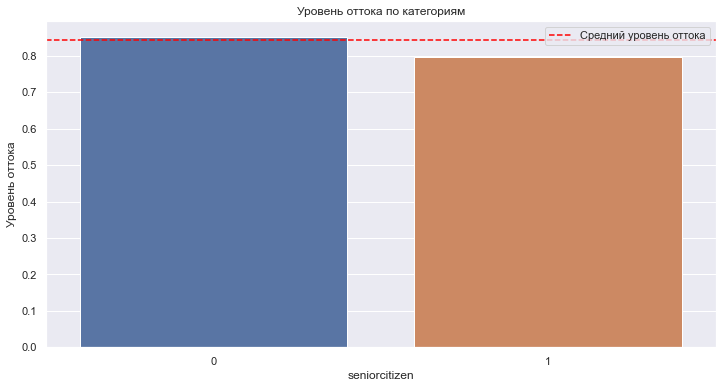

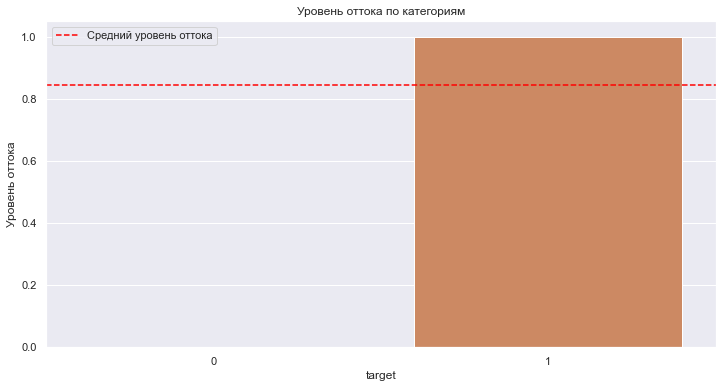

In [40]:
for idx, column in enumerate(categorial_columns):
    outflow_cat(column)

В зоне риска находятся пользователи, которые:
* платят ежемесячно;
* не имеют партнера;
* которые не подключали какие-либо дополнительные услуги;
* не пенсионеры (это может быть связано с тем, что зачастую именно молодые люди пробуют и/или сравнивают разные пакеты/услуги, в то время как пожилые люди, во-первых, часто меньше разбираются в этом, во-вторых, им зачастую это не нужно - что подключили, то подключили, главное, чтобы хорошо работало).

На основе полученной информации можно составить портрет пользователя, который вскоре может покинуть компанию:
* это молодой человек (пол не важен); 
* возможно, один, не в браке; 
* без дополнительных услуг;
* пользуется услугами этой компании больше года;
* его может не устраивать общая плата за услуги: допустим, он нашел более выгодный пакает у конкурентов  и считает, что в этой компании он переплачивает.


То есть в зоне риска находятся клиенты, которые уже прошли пероид адаптации и уже неплохо разбираются в этом рынке.

Посмотрим на матрицу корреляции, предварительно удалив даты из df.

In [41]:
df= df.drop(['begindate'], axis=1)

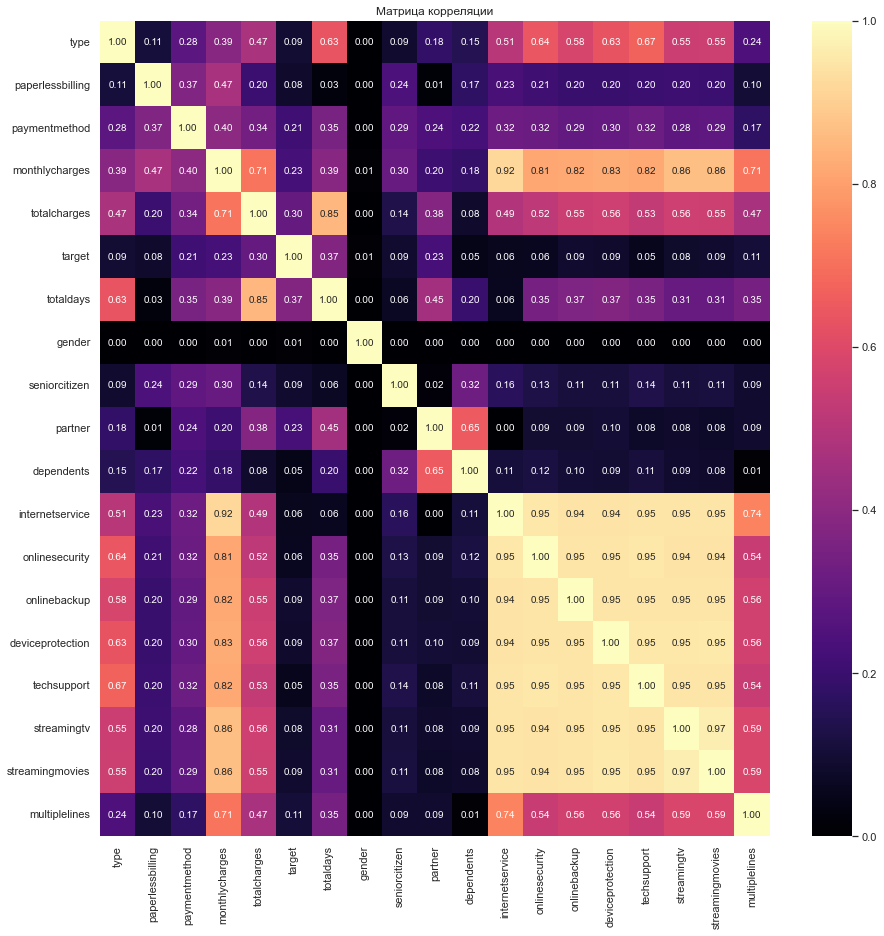

In [42]:
matrix_corr = df.drop('customerid', axis=1).phik_matrix(interval_cols=['monthlycharges', 'totalcharges','totaldays'])
plt.figure(figsize=(15, 15)) 
sns.heatmap(matrix_corr, annot=True, fmt=".2f", cmap='magma', annot_kws={"size": 10})
plt.title('Матрица корреляции')
plt.show()

Удалим из-за высокой корреляции следующие столбцы: internetservice, onlinesecurity, deviceprotection, streamingtv, streamingmovies, techsupport. Удалим gender, так как он почти не коррелирует с target.

In [43]:
df1 = df.copy()

In [44]:
df1.columns

Index(['customerid', 'type', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'target', 'totaldays', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines'],
      dtype='object')

In [45]:
df1= df1.drop(['internetservice', 'onlinesecurity', 'deviceprotection', 'streamingtv', 
               'streamingmovies', 'techsupport', 'gender', 'onlinebackup', 'totaldays'], axis=1)

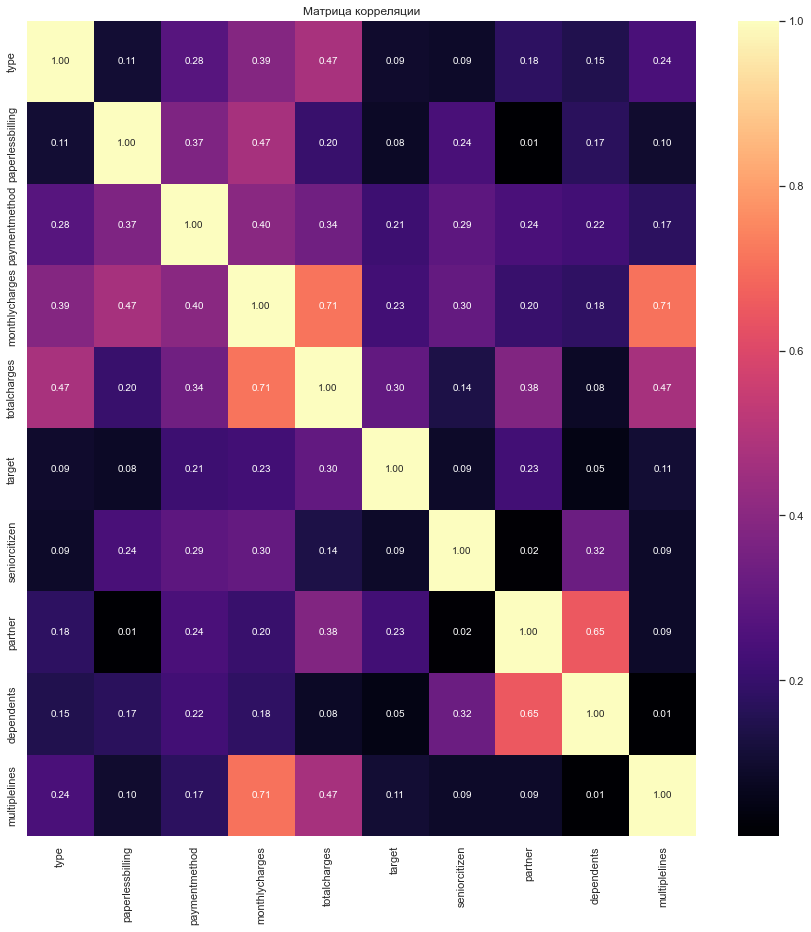

In [46]:
matrix_corr = df1.drop('customerid', axis=1).phik_matrix(interval_cols=['monthlycharges','totalcharges'])
plt.figure(figsize=(15, 15)) 
sns.heatmap(matrix_corr, annot=True, fmt=".2f", cmap='magma', annot_kws={"size": 10})
plt.title('Матрица корреляции')
plt.show()

Теперь высокой корреляции не наблюдается. 

## Подготовка данных

Установим `customerid` в качестве индекса

In [47]:
df1 = df1.set_index('customerid')

In [48]:
df1.head(15)

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,seniorcitizen,partner,dependents,multiplelines
customerid,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,1,0,Yes,No,No_service
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1,0,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,1,0,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1,0,No,No,No_service
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,1,0,No,No,No
9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,1150.96,1,0,No,No,Yes
1452-KIOVK,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,1,0,No,Yes,Yes
6713-OKOMC,Month-to-month,No,Mailed check,29.75,300.48,1,0,No,No,No_service
7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3573.68,1,0,Yes,No,Yes


Разделим на train и test выборки и преобразуем категориальные данные с помощь get_dummies, масштабируем числовые с помощью StandarScaler.

In [49]:
X = df1.drop(columns=['target'])
y = df1['target']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE
                                                   )

In [51]:
cat=['type', 'paperlessbilling', 'paymentmethod',
       'seniorcitizen', 'partner', 'dependents', 'multiplelines']
num=['totalcharges', 'monthlycharges']

In [52]:
df1.columns

Index(['type', 'paperlessbilling', 'paymentmethod', 'monthlycharges',
       'totalcharges', 'target', 'seniorcitizen', 'partner', 'dependents',
       'multiplelines'],
      dtype='object')

**Подготовка данных для RandomForestClassifier**

In [53]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ord = encoder.fit_transform(X_train[cat])
X_test_ord = encoder.transform(X_test[cat])

In [54]:
X_train_ord = pd.DataFrame(X_train_ord, columns=cat)
X_test_ord = pd.DataFrame(X_test_ord, columns=cat)
X_test_ord

,type,paperlessbilling,paymentmethod,seniorcitizen,partner,dependents,multiplelines
0,2.0,0.0,0.0,0.0,1.0,0.0,2.0
1,2.0,0.0,1.0,0.0,1.0,1.0,2.0
2,0.0,1.0,2.0,0.0,0.0,0.0,0.0
3,2.0,1.0,1.0,1.0,0.0,0.0,2.0
4,0.0,1.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1756,2.0,1.0,2.0,0.0,0.0,0.0,2.0
1757,0.0,1.0,2.0,0.0,0.0,0.0,2.0
1758,1.0,1.0,2.0,0.0,0.0,0.0,0.0
1759,1.0,0.0,3.0,0.0,0.0,0.0,0.0


Масштабируем количественные признаки с помощью StandardScaler.

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num])
X_test_scaled = scaler.transform(X_test[num])

In [56]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num)

In [57]:
X_train_forest = pd.concat((X_train_ord, X_train_scaled), axis=1)
X_test_forest = pd.concat((X_test_ord, X_test_scaled), axis=1)

In [58]:
X_train_forest.head(15)

,type,paperlessbilling,paymentmethod,seniorcitizen,partner,dependents,multiplelines,totalcharges,monthlycharges
0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,-0.307391,0.320908
1,1.0,1.0,0.0,0.0,1.0,0.0,2.0,1.737517,1.474037
2,2.0,0.0,3.0,0.0,0.0,1.0,2.0,1.043361,1.194491
3,0.0,1.0,2.0,0.0,0.0,0.0,1.0,-0.526622,-1.133400
4,0.0,1.0,2.0,1.0,0.0,0.0,2.0,-0.472235,0.342539
5,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.664964,0.104592
6,0.0,1.0,2.0,0.0,0.0,0.0,0.0,-0.907262,-0.414566
7,0.0,1.0,1.0,0.0,1.0,1.0,2.0,-0.476156,0.324236
8,0.0,1.0,1.0,0.0,0.0,0.0,2.0,-0.731959,-0.338024
9,2.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.031364,0.124559


**Подготовка данных для LogisticRegression**

In [59]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

In [60]:
X_train_ohe = encoder.fit_transform(X_train[cat])
X_test_ohe = encoder.transform(X_test[cat])

encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['type_One year', 'type_Two year', 'paperlessbilling_Yes',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'seniorcitizen_1', 'partner_Yes', 'dependents_Yes',
       'multiplelines_No_service', 'multiplelines_Yes'], dtype=object)

In [61]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [62]:
X_train_log = pd.concat((X_train_ohe, X_train_scaled), axis=1)
X_test_log = pd.concat((X_test_ohe, X_test_scaled), axis=1)

In [63]:
X_train_log.head(15)

,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,seniorcitizen_1,partner_Yes,dependents_Yes,multiplelines_No_service,multiplelines_Yes,totalcharges,monthlycharges
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.307391,0.320908
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.737517,1.474037
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.043361,1.194491
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.526622,-1.133400
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.472235,0.342539
5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.664964,0.104592
6,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.907262,-0.414566
7,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,-0.476156,0.324236
8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.731959,-0.338024
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.031364,0.124559


In [64]:
X_train.shape[0] == y_train.shape[0]

True

In [65]:
X_train_forest.shape[0] == y_train.shape[0]

True

In [66]:
X_train_log.shape[0] == y_train.shape[0]

True

Мы установили customerid в качестве индекса, разбили нашу выборку на test и train, подготовив данные.

## Обучение моделей машинного обучения

Обучим три модели на тренировачной выборке: RandomForestClassifier, LogisticRegression и CatBoostClassifier.

**RandomForestClassifier** 

In [67]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid = {
  'n_estimators': [50, 100, 200, 500],
  'max_depth': [5, 10, 20],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4]
}
randomized_search = RandomizedSearchCV(
    model,
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
randomized_search.fit(X_train_forest, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Метрика лучшей модели на кросс-валидации: 0.8


**LogisticRegression**

In [68]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

model = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring='roc_auc')

grid_search.fit(X_train_log, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', round(grid_search.best_score_, 2))

Лучшая модель и её параметры:

 {'C': 1}
Метрика лучшей модели на кросс-валидации: 0.75


**CatBoostClassifier**

In [69]:
param_grid = {
    'learning_rate': [1, 0.5],
    'iterations': [50, 150],
    'l2_leaf_reg': [2, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

cat_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring='roc_auc')

cat_search.fit(X_train_log, y_train)

print('Лучшая модель и её параметры:\n\n', cat_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', round(cat_search.best_score_, 2))

Лучшая модель и её параметры:

 {'iterations': 50, 'l2_leaf_reg': 9, 'learning_rate': 0.5}
Метрика лучшей модели на кросс-валидации: 0.81


**Вывод:** Лучшей моделью оказалась CatBoostClassifier с параметрами {'iterations': 50, 'l2_leaf_reg': 9, 'learning_rate': 0.5}. Протестируем ее на тестовой выборке.

## Выбор лучшей модели

In [70]:
probabilities = cat_search.predict_proba(X_test_log)[:,1]
print('Площадь ROC-кривой:', round(roc_auc_score(y_test, probabilities),2))

Площадь ROC-кривой: 0.84


Посчитаем также accuracy для более легкой интерпретируемости модели.

In [71]:
predicted_classes = np.where(probabilities >= 0.5, 1, 0)
accuracy = accuracy_score(y_test, predicted_classes)
print("Accuracy:", accuracy)

Accuracy: 0.8659852356615559


Значение Accuracy, или точность, 0.866  указывает на то, что модель имеет хорошую производительность, так как более 86% предсказаний верны.

Проверим лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели DummyClassifier.

In [72]:
dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

print('Площадь ROC-кривой:', roc_auc_score(y_test, y_pred))

Площадь ROC-кривой: 0.5


Видим, что модель CatBoostClassifier прошла проверку на адекватность: она хорошо различает классы независимо от их распределения.

Вычислим важность признаков для лучшей модели.

,importances
totalcharges,36.389912
monthlycharges,17.497515
type_Two year,13.627689
type_One year,7.797946
partner_Yes,5.916557
multiplelines_Yes,4.604226
multiplelines_No_service,3.547756
paymentmethod_Credit card (automatic),2.960150
dependents_Yes,2.404827
paymentmethod_Mailed check,2.105347


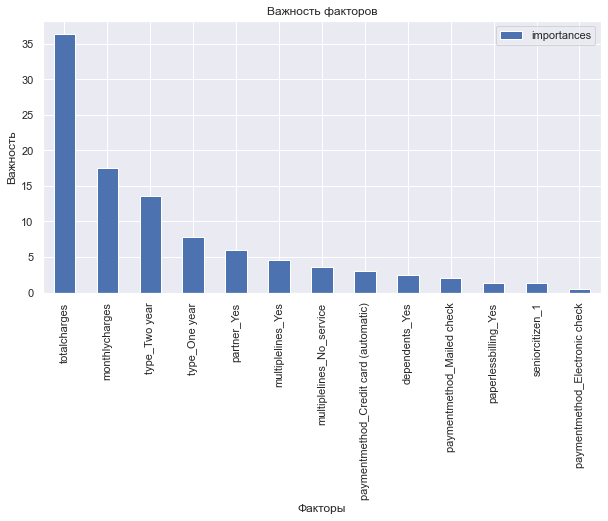

In [73]:
importance = pd.DataFrame(cat_search.best_estimator_.feature_importances_, index = X_test_log.columns, columns=['importances'])
importance = importance.sort_values(by='importances', ascending=False)
display(importance)

importance.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.xlabel('Факторы') 
plt.ylabel('Важность')
plt.show()

* Наиболее важный фактор - это общая сумма плат.
* Далее идут такие факторы, как ежемесячная плата и тип.

Проанализируем матрицу ошибок.

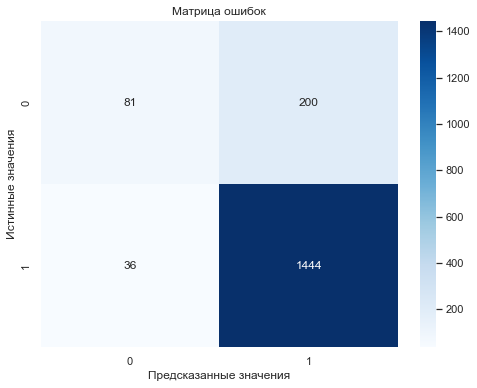

In [74]:
cm = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
      xticklabels=np.unique(y_test),
      yticklabels=np.unique(y_test))
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.title("Матрица ошибок")

plt.show()

Матрица показывает следующее:
* TP (Верно положительные): 1444 пользователя, которые еще пользуются услугами и были предсказаны как действительные пользователи.
* TN (Верно отрицательные): 81 пользователь, которые уже не пользуются услугами и были предсказаны как недействительные пользователи.
* FP (Ложно положительные): 200 пользователей, которые уже не пользуются услугами, но были предсказаны как действительные пользователи.
* FN (Ложно отрицательные): 36 пользователей, которые еще пользуются услугами, но модель предсказала, что они недействительные пользователи.

## Общий вывод и рекомендации заказчику

В этой работе было проведено исследование, которое поможет заказчику предсказать отток клиентов.
* Были добавлены дополнительные признакми: TotalDays и target, который показывал, пользуется ли еще абонент услугами.
* Проанализировали все признаки, посмотрели на корреляцию, удалили те, которые имели недопустимые значения.
* Были построены три модели, лучшей оказалась CatBoostClassifier с параметрами {'iterations': 50, 'l2_leaf_reg': 9, 'learning_rate': 0.5}. 
* На тестовой выборке ее площадь ROC-кривой составила 0.84.
* Acсuracy на тестовой выборке составила 0.87. То есть точность нашей модели составляет 87%.
* Решающим фактором является общая сумма плат пользователя в этой компании.
* На следующем месте - ежемесячная плата. На это тоже стоит обратить внимание.

На основе полученной информации можно составить портрет пользователя, который вскоре может покинуть компанию:
* это молодой человек (пол не важен); 
* возможно, один, не в браке; 
* без дополнительных услуг;
* пользуется услугами этой компании больше года;
* его может не устраивать общая плата за услуги: допустим, он нашел более выгодный пакает у конкурентов  и считает, что в этой компании он переплачивает.


То есть в зоне риска находятся клиенты, которые уже прошли пероид адаптации и уже неплохо разбираются в этом рынке.
Можно попробовать предлагать специальные условия пользователям, которы уже пользуются услугами определенный период или предложить им тариф за меньшую плату.